In [1]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as transforms
import utils
import math
import random
import argparse
import os
import sys
#import models
from simba import SimBA

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import PIL
from IPython.display import display

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import tqdm
# GPU 장치 사용 설정
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
imsize = 224

preprocess = transforms.Compose([
    transforms.Resize((imsize, imsize)), # 이미지 사이즈 변경
    transforms.ToTensor(), # [0, 255] → [0, 1] torch.Tensor
])

data_dir = 'Small-ImageNet-Validation-Dataset-1000-Classes/ILSVRC2012_img_val_subset'

val_dataset = datasets.ImageFolder(os.path.join(data_dir), preprocess)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)
print('전체 이미지 개수:', len(val_dataset))

class_names = val_dataset.classes
print('클래스의 개수:', len(class_names))

# ImageNet 설정 파일에서 1,000개의 레이블을 불러오기
with open('Small-ImageNet-Validation-Dataset-1000-Classes/imagenet.json') as f:
    imagenet_labels = json.load(f)

전체 이미지 개수: 5000
클래스의 개수: 1000


In [4]:
# 입력 데이터를 정규화(normalization)하는 클래스
class Normalize(nn.Module) :
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std
    
def get_distance(a, b):
    l0 = torch.norm((a - b).view(a.shape[0], -1), p=0, dim=1)
    l2 = torch.norm((a - b).view(a.shape[0], -1), p=2, dim=1)
    mse = (a - b).view(a.shape[0], -1).pow(2).mean(1)
    linf = torch.norm((a - b).view(a.shape[0], -1), p=float('inf'), dim=1)
    return l0, l2, mse, linf

def imshow_batch(image, title):
    # torch.Tensor => numpy 변환하기
    image = image.numpy().transpose((1, 2, 0))
    # 화면에 이미지 출력하기
    plt.imshow(image)
    plt.title(title)
    plt.show()

In [5]:
# 이 코드는 바꾸실 수 없습니다.
black_box_model = nn.Sequential(
    # 입력 정규화 레이어를 추가하기
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    torchvision.models.inception_v3(pretrained=True)
).to(device).eval()

c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\minki\miniconda3\envs\dl_venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def black_box_attack_validate(black_box_model, attacker , max_iters=100):
    criterion = nn.CrossEntropyLoss()
    start_time = time.time()

    running_loss = 0.
    running_corrects = 0
    running_length = 0

    running_l0 = 0
    running_l2 = 0
    running_mse = 0
    running_linf = 0

    for i, (inputs, basic_labels) in tqdm.tqdm(enumerate(val_dataloader)):
        inputs = inputs.to(device)
        labels = torch.zeros_like(basic_labels).long().to(device)
        for j in range(labels.shape[0]):
            labels[j] = int(class_names[basic_labels[j]])
        labels = labels.to(device)


        adv_image, probs, succs, queries, l2_norms, linf_norms = attacker.simba_batch(
        inputs, labels, max_iters, 224, 7, 0.2, linf_bound=16/255,
        order='diag', targeted=False, pixel_attack=True, log_every=10)

        outputs = black_box_model(adv_image)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        running_length += labels.shape[0]

        l0, l2, mse, linf = get_distance(adv_image, inputs)
        running_l0 += l0.sum().item()
        running_l2 += l2.sum().item()
        running_mse += mse.sum().item()
        running_linf += linf.sum().item()

        if i == 0:
            print('The dimension of an image tensor:', inputs.shape[1:])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(adv_image[:4])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[:4]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[:4]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[:4]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 1}: {label} ({imagenet_index})')
            images = torchvision.utils.make_grid(adv_image[4:8])
            imshow_batch(images.cpu(), title='original labels:' + str([int(x) for x in labels[4:8]]) +
                          '\npredicted labels:' + str([int(x) for x in preds[4:8]]))
            print('Original labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(labels[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')
            print('Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>')
            for j, imagenet_index in enumerate(preds[4:8]):
                label = imagenet_labels[imagenet_index]
                print(f'Image #{j + 5}: {label} ({imagenet_index})')

        if i % 10 == 0:
            cur_running_loss = running_loss / running_length
            running_acc = running_corrects / running_length * 100.
            print('[Step #{}] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(i, cur_running_loss, running_acc, time.time() - start_time, running_length))

    epoch_loss = running_loss / len(val_dataset)
    epoch_acc = running_corrects / len(val_dataset) * 100.
    print('[Validation] Loss: {:.4f} Accuracy: {:.4f}% Time elapsed: {:.4f}s (total {} images)'.format(epoch_loss, epoch_acc, time.time() - start_time, len(val_dataset)))

    print('[Size of Perturbation]')
    print('Average L0 distance (the number of changed parameters):', running_l0 / len(val_dataset))
    print('Average L2 distance:', running_l2 / len(val_dataset))
    print('Average MSE:', running_mse / len(val_dataset))
    print('Average Linf distance (the maximum changed values):', running_linf / len(val_dataset))

0it [00:00, ?it/s]

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


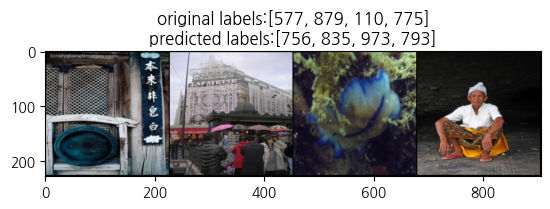

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: gong, tam-tam (577)
Image #2: umbrella (879)
Image #3: flatworm, platyhelminth (110)
Image #4: sarong (775)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: rain barrel (756)
Image #2: sundial (835)
Image #3: coral reef (973)
Image #4: shower cap (793)


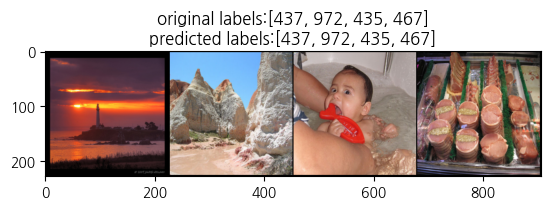

1it [00:11, 11.33s/it]

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: beacon, lighthouse, beacon light, pharos (437)
Image #6: cliff, drop, drop-off (972)
Image #7: bathtub, bathing tub, bath, tub (435)
Image #8: butcher shop, meat market (467)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: beacon, lighthouse, beacon light, pharos (437)
Image #6: cliff, drop, drop-off (972)
Image #7: bathtub, bathing tub, bath, tub (435)
Image #8: butcher shop, meat market (467)
[Step #0] Loss: 0.1045 Accuracy: 62.5000% Time elapsed: 18.9203s (total 32 images)


11it [01:40,  8.87s/it]

[Step #10] Loss: 0.0586 Accuracy: 71.5909% Time elapsed: 108.2516s (total 352 images)


21it [03:12,  9.32s/it]

[Step #20] Loss: 0.0582 Accuracy: 70.8333% Time elapsed: 200.4392s (total 672 images)


31it [04:47,  9.42s/it]

[Step #30] Loss: 0.0611 Accuracy: 68.6492% Time elapsed: 294.8661s (total 992 images)


41it [06:24, 10.55s/it]

[Step #40] Loss: 0.0603 Accuracy: 69.2835% Time elapsed: 392.4583s (total 1312 images)


51it [08:05,  9.93s/it]

[Step #50] Loss: 0.0593 Accuracy: 69.4240% Time elapsed: 493.3527s (total 1632 images)


61it [09:45,  9.92s/it]

[Step #60] Loss: 0.0593 Accuracy: 69.0574% Time elapsed: 592.9445s (total 1952 images)


71it [11:27,  9.86s/it]

[Step #70] Loss: 0.0598 Accuracy: 68.6620% Time elapsed: 695.1004s (total 2272 images)


81it [13:01,  9.11s/it]

[Step #80] Loss: 0.0598 Accuracy: 67.9398% Time elapsed: 789.4255s (total 2592 images)


91it [14:36,  9.32s/it]

[Step #90] Loss: 0.0600 Accuracy: 68.0632% Time elapsed: 884.4455s (total 2912 images)


101it [16:13,  9.44s/it]

[Step #100] Loss: 0.0606 Accuracy: 67.7599% Time elapsed: 980.8178s (total 3232 images)


111it [17:49,  9.64s/it]

[Step #110] Loss: 0.0607 Accuracy: 67.7928% Time elapsed: 1077.4820s (total 3552 images)


121it [19:30, 10.19s/it]

[Step #120] Loss: 0.0606 Accuracy: 67.9494% Time elapsed: 1177.8596s (total 3872 images)


131it [21:10, 10.03s/it]

[Step #130] Loss: 0.0606 Accuracy: 68.2013% Time elapsed: 1278.4026s (total 4192 images)


141it [22:46,  9.56s/it]

[Step #140] Loss: 0.0606 Accuracy: 68.0408% Time elapsed: 1374.1675s (total 4512 images)


151it [24:23,  9.75s/it]

[Step #150] Loss: 0.0607 Accuracy: 67.8601% Time elapsed: 1471.1627s (total 4832 images)


157it [25:19,  9.68s/it]

[Validation] Loss: 0.0609 Accuracy: 67.7400% Time elapsed: 1526.7737s (total 5000 images)
[Size of Perturbation]
Average L0 distance (the number of changed parameters): 5.095
Average L2 distance: 0.17371534852981568
Average MSE: 1.2383794429297267e-06
Average Linf distance (the maximum changed values): 0.040222746187448505


In [7]:
# 블랙박스 공격 예제 코드입니다.
custom_attack = SimBA(black_box_model, 'imagenet', 224,'cuda')
black_box_attack_validate(black_box_model, custom_attack , max_iters=100)

0it [00:00, ?it/s]

The dimension of an image tensor: torch.Size([3, 224, 224])
[Prediction Result Examples]


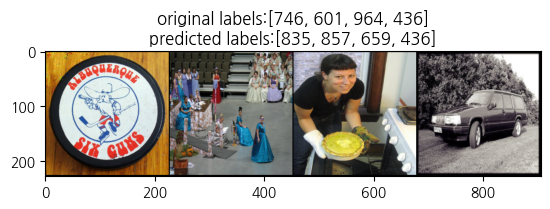

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: puck, hockey puck (746)
Image #2: hoopskirt, crinoline (601)
Image #3: potpie (964)
Image #4: beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (436)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #1: sundial (835)
Image #2: throne (857)
Image #3: mixing bowl (659)
Image #4: beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon (436)


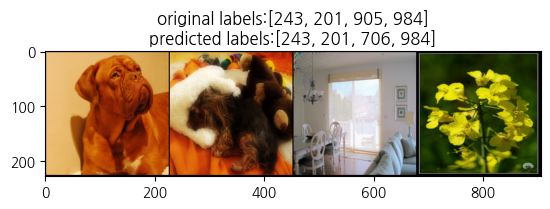

Original labels >>>>>>>>>>>>>>>>>>>>>>>>>


1it [16:06, 966.01s/it]

Image #5: bull mastiff (243)
Image #6: silky terrier, Sydney silky (201)
Image #7: window shade (905)
Image #8: rapeseed (984)
Predicted labels >>>>>>>>>>>>>>>>>>>>>>>>>
Image #5: bull mastiff (243)
Image #6: silky terrier, Sydney silky (201)
Image #7: patio, terrace (706)
Image #8: rapeseed (984)
[Step #0] Loss: 0.0654 Accuracy: 68.7500% Time elapsed: 974.0640s (total 32 images)


1it [25:29, 1529.34s/it]


KeyboardInterrupt: 

In [9]:
# 블랙박스 공격 예제 코드입니다.
custom_attack = SimBA(black_box_model, 'imagenet', 224,'cuda')
black_box_attack_validate(black_box_model, custom_attack , max_iters=11000)

In [ ]:
attacker = SimBA(black_box_model, 'imagenet', 224)

In [ ]:
adv, probs, succs, queries, l2_norms, linf_norms = attacker.simba_batch(
        images_batch, labels_batch, max_iters, args.freq_dims, args.stride, args.epsilon, linf_bound=args.linf_bound,
        order=args.order, targeted=args.targeted, pixel_attack=args.pixel_attack, log_every=args.log_every)

In [15]:
!python run_simba.py --data_root Small-ImageNet-Validation-Dataset-1000-Classes/ILSVRC2012_img_val_subset --num_iters 10000 --pixel_attack  --freq_dims 224 --batch_size 32 --epsilon 16/255


^C
